In [352]:
# prototype code which I don't think is going to work past n=2

In [1]:
%matplotlib inline
from autograd import numpy as np
import scipy.spatial
import bayesian_pdes as bpdes
import six
import sympy as sp
import matplotlib.pyplot as plt
import autograd

# Forward Problem

In [44]:
ls = 0.1
alpha = 1.0
def k(x, x_bar):
    return np.exp(-(x[:,0]-x_bar[:,0])**2 / (2*ls**2)) * np.exp(-(x[:,1]-x_bar[:,1])**2 / (2*ls**2))

In [40]:
def T(k):
    d1 = autograd.grad(k, 1)
    d2 = autograd.grad(autograd.grad(k,0), 0)
    def __ret__(*args):
        return d1(*args) - d2(*args)
    return __ret__
def T_bar(k):
    d1 = autograd.grad(k, 3)
    d2 = autograd.grad(autograd.grad(k, 2), 2)
    def __ret__(*args):
        return d1(*args) - d2(*args)
    return __ret__
    
def B(k):
    return k
B_bar = B

ops = [T, B]
ops_bar = [T_bar, B_bar]

In [42]:
def update_kern(cur_kern, obs):
    T_k = T(cur_kern)
    T_bar_k = T_bar(cur_kern)
    T_T_bar_k = T_bar(T_k)
    
    a = cur_kern(obs[1], obs[1])
    b = T_k(obs[0], obs[1])
    c = T_bar_k(obs[1], obs[0])
    d = T_T_bar_k(obs[0], obs[0])
    LLbar = np.row_stack([np.column_stack([a, b]), np.column_stack([c,d])])
    inv_mat = np.linalg.inv(LLbar)
    
    def __ret__(x, x_bar):
        left_a = T_bar_k(x, obs[0])
        right_a = T_k(obs[0], x_bar)
        left_b = kern(x, obs[1])
        right_b = kern(obs[1], x_bar)
        
        left = np.row_stack([left_a, left_b])
        right = np.row_stack([right_a, right_b])
        
        return cur_kern(x, t, y, t_prime) - np.dot(left, np.dot(inv_mat, right))
    return __ret__

In [37]:
def augment_with_time(pts, t):
    return np.column_stack([pts, t*np.ones(pts.shape[0])])

In [32]:
L = 1.

In [33]:
def g(x):
    return np.zeros_like(x[:,0])
def b(x):
    return np.ones_like(x[:,0])

In [34]:
def u_0(x):
    return np.zeros_like(x)

In [35]:
x_pts = np.linspace(0,L,11)[:,None]
interior = x_pts[1:-1]
bdy = x_pts[[0, -1]]

fun_args = np.array([0.1, 1.0])

test_pts = np.linspace(0,L,21)[:,None]

In [43]:
update_kern(k, [augment_with_time(interior, 0.1), augment_with_time(bdy, 0.1)])

ValueError: operands could not be broadcast together with shapes (9,) (2,) 

In [121]:
dt = 0.1

In [316]:
def calc_diff_LLbar(operators, operators_bar, prev_obs, new_obs, op_cache, fun_args=None):
    # and build the 2D matrix
    LLbar = []

    for op, obs_1 in zip(operators, new_obs):
        tmp = []
        for op_bar, obs_2 in zip(operators_bar, prev_obs):
            points_1, _ = obs_1
            points_2, _ = obs_2

            fun_op = op_cache[(op, op_bar)]

            applied = fun_op(points_1, points_2, fun_args)
            tmp.append(applied)
        LLbar.append(np.concatenate(tmp, axis=1))

    return np.concatenate(LLbar)

In [345]:
# first k_1
t = dt

interior_n = np.column_stack([interior, t*np.ones_like(interior)])
bdy_n = np.column_stack([bdy, t*np.ones_like(bdy)])
test_n = np.column_stack([test_pts, t*np.ones_like(test_pts)])

int_obs = [interior_n, g(interior_n)]
bdy_obs = [bdy_n, b(bdy_n)]
obs = [int_obs, bdy_obs]

L_Lbar_n = bpdes.collocation.calc_LLbar(ops, ops_bar, obs, op_system, fun_args)
L_Lbar_n_inv = np.linalg.inv(L_Lbar_n)

k, k_bar = bpdes.collocation.calc_side_matrices(ops, ops_bar, obs, test_n, op_system, fun_args)

kern = op_system[()](test_n, test_n, fun_args) - np.dot(k_bar, np.dot(L_Lbar_n_inv, k))


A = [L_Lbar_n_inv]
B = L_Lbar_n_inv
C = L_Lbar_n_inv
D_left = L_Lbar_n_inv
D_right = L_Lbar_n_inv

obs_n = [obs]

In [348]:
# k_n
n = 3
t = n*dt

interior_n = np.column_stack([interior, t*np.ones_like(interior)])
bdy_n = np.column_stack([bdy, t*np.ones_like(bdy)])
test_n = np.column_stack([test_pts, t*np.ones_like(test_pts)])

int_obs = [interior_n, g(interior_n)]
bdy_obs = [bdy_n, b(bdy_n)]
obs = [int_obs, bdy_obs]

# compute A
A_mat = 0
diff_A_mat = 0
# first loop through all the prior iterations and compute the contribution
for i in xrange(n-1):
    obs_i = obs_n[i]
    inv_mat = A[i]
    k_i, k_bar_i = bpdes.collocation.calc_side_matrices(ops, ops_bar, obs_i, test_n, op_system, fun_args)
    diff_k_i = calc_diff_LLbar(ops, ops_bar, obs_i, obs, op_system, fun_args)
    A_mat = A_mat + np.dot(k_bar_i, np.dot(inv_mat, k_i))
    diff_A_mat = diff_A_mat + np.dot(diff_k_i, np.dot(inv_mat, diff_k_i.T))

# calculate the matrix describing the correlation between the last and current time index
# calc_diff_LLBar has new_obs on the left!
transition_mat = calc_diff_LLbar(ops, ops_bar, obs_i, obs, op_system, fun_args)
transition_from_zero = calc_diff_LLbar(ops, ops_bar, obs_n[0], obs, op_system, fun_args)

diff_k_eval = bpdes.collocation.calc_LLbar(ops, ops_bar, obs, op_system, fun_args)
last_diff_k_n = diff_k_eval - diff_A_mat
if n > 2:
    diff_B_mat = np.dot(transition_from_zero, np.dot(B, transition_mat.T))
    diff_C_mat = np.dot(transition_mat, np.dot(C, transition_from_zero.T))
    diff_D_mat = np.dot(transition_from_zero, np.dot(D, transition_from_zero.T))
    last_diff_k_n = last_diff_k_n + diff_B_mat + diff_C_mat - diff_D_mat

# now we know the new contribution in T_T_bar_k - invert it
new_inv_mat = np.linalg.inv(last_diff_k_n)

# compute all of the side matrices
k_1, k_bar_1 = bpdes.collocation.calc_side_matrices(ops, ops_bar, obs_n[0], test_n, op_system, fun_args)
k_n, k_bar_n = bpdes.collocation.calc_side_matrices(ops, ops_bar, obs, test_n, op_system, fun_args)

# add in the contribution from the new inv mat
A_mat = A_mat + np.dot(k_bar_n, np.dot(new_inv_mat, k_n))

# update all of the matrices with this new info
B = np.dot(B, np.dot(transition_mat.T, new_inv_mat))
C = np.dot(np.dot(new_inv_mat, transition_mat), C)
D_left = np.dot(D_left, transition_mat.T)
D_right = np.dot(transition_mat, D_right)

# compute the matrices for the sum
B_mat = np.dot(k_bar_1, np.dot(B, k_n))
C_mat = np.dot(k_bar_n, np.dot(C, k_1))
D_mat = np.dot(k_bar_1, np.dot(D_left, np.dot(new_inv_mat, np.dot(D_right, k_1))))

# and the kernel...
k_eval = op_system[()](test_n, test_n, fun_args)

# then the evaluated kernel matrix
kern = k_eval - A_mat + B_mat + C_mat - D_mat

# lastly update for the next iteration
D_left = np.dot(D_left, new_inv_mat)
D_right = np.dot(new_inv_mat, D_right)

obs_n.append(obs)
A.append(new_inv_mat)

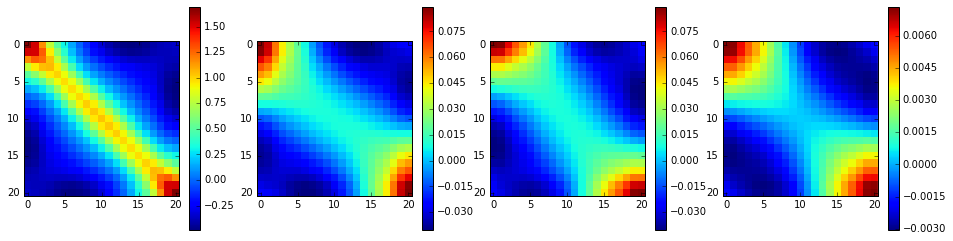

In [349]:
plt.figure(figsize=(16,4))
plt.subplot(141);
plt.imshow(A_mat, interpolation='None'); plt.colorbar()
plt.subplot(142);
plt.imshow(B_mat, interpolation='None'); plt.colorbar()
plt.subplot(143);
plt.imshow(C_mat, interpolation='None'); plt.colorbar()
plt.subplot(144);
plt.imshow(D_mat, interpolation='None'); plt.colorbar()

In [ ]:
plt.matshow(A_mat); plt.colorbar()

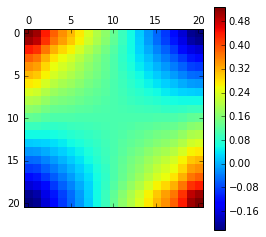

In [184]:
plt.matshow(np.dot(k_bar_n, np.dot(new_inv_mat, k_n)))
plt.colorbar()

In [419]:
mu

array([[ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan]])

In [420]:
posterior = bpdes.collocate(op_system.operators, op_system.operators_bar, None, None, obs, op_system, fun_args=np.array([0.1, 1.0]))

TypeError: k() takes exactly 5 arguments (6 given)

In [ ]:
mu, cov = posterior(np.column_stack([x_pts, dt*np.ones_like(x_pts)]))

In [ ]:
plt.plot(mu)

In [ ]:
# this gives the propagation of IID noise
def sequential_parabolic():
    

In [ ]:
# so now, how to proceed. I know H === I. I know \Phi = some linear operator. 